In [8]:
import py3Dmol
import automol
from pathlib import Path
from python import sql
import matplotlib.pyplot as plt

xyz_file = "/home/tns97255/PES-Sandbox/data/AMChI=1/C5H9O/c1-4-5(6-4)3-2-7-1/h4-5H,1-3H2/t4-,5+/m0/s1/k7-2/f7-1/r1/freq.log.v006.xyz"

## Animate from File

In [ ]:
xyz_block = Path(xyz_file).read_text()
cleaned_xyz_block = xyz_block.replace(">\n", "")

viewer = py3Dmol.view()
viewer.addModelsAsFrames(cleaned_xyz_block, "xyz")

viewer.setStyle({"stick": {}, "sphere": {"scale": 0.3}})

viewer.zoomTo()
viewer.animate({"loop": "backAndForth"})
viewer.show()

## View Reaction Product(s)

In [ ]:
reactants = ["C[CH]CC1CO1"]
products = ["CCCC1[CH]O1"]

In [ ]:
rxns = automol.reac.from_smiles(reactants, products)

for rxn in rxns:
    ts_graph = automol.reac.ts_graph(rxn)
    ts_amchi = automol.graph.amchi(ts_graph)

    print(ts_amchi)
    automol.reac.display(rxn)

    try:
        ts_geom = automol.graph.geometry(ts_graph)
        automol.geom.display(ts_geom, ts_graph)
        
    except Exception:
        continue

## Draw Potential Energy Surface(s)

In [3]:
reactants = ["[CH2]C[C@H]1O[C@H]1C"]

data_dir = Path.cwd() / "data"

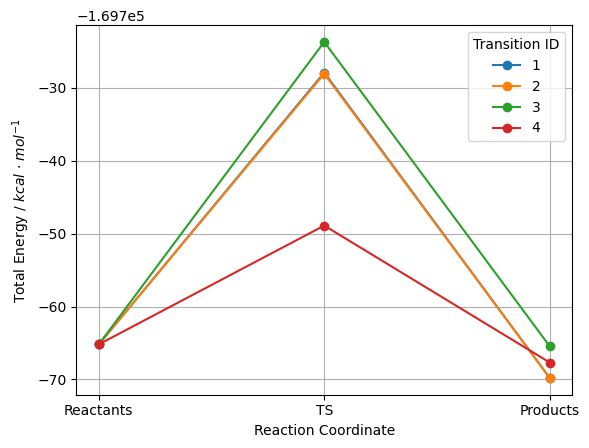

In [ ]:
connection = sql.connect(data_dir)
cursor = connection.cursor()

placeholders = ', '.join(['?'] * len(reactants))
cursor.execute(
    f"""SELECT id
    FROM stationary
    WHERE amchi IN ({placeholders})
       OR smiles IN ({placeholders})""",
    reactants * 2
)
stationary_ids = [sid for (sid,) in cursor.fetchall()]

# --- Predefine queries ---
transition_q = """
SELECT id, reactant_1, reactant_2, product_1, product_2
FROM transition
WHERE ? IN (reactant_1, reactant_2, product_1, product_2)
"""

transition_energy_q = """
SELECT total_energy
FROM energies
WHERE transition_id = ?
"""

stationary_energy_q = """
SELECT total_energy
FROM energies
WHERE stationary_id = ?
"""

def total_stationary_energy(ids):
    """Sums energies for a list of IDs, skipping None."""
    energy = 0.0
    for i in ids:
        if i is not None:
            cursor.execute(stationary_energy_q, (i,))
            energy += float(cursor.fetchone()[0])
    return energy

energy_surfaces = {}

for sid in stationary_ids:
    cursor.execute(transition_q, (sid,))
    for tid, r1, r2, p1, p2 in cursor.fetchall():

        cursor.execute(transition_energy_q, (tid,))
        ts_energy = float(cursor.fetchone()[0])

        energy_surfaces[tid] = {
            "reactants": total_stationary_energy([r1, r2]),
            "transition": ts_energy,
            "products": total_stationary_energy([p1, p2]),
        }

plt.figure()

x = [0, 1, 2]
for tid, surface in energy_surfaces.items():
    y = [surface["reactants"], surface["transition"], surface["products"]]
    plt.plot(x, y, marker="o", label=tid)

plt.xticks(x, ["Reactants", "TS", "Products"])
plt.ylabel(r"Total Energy / $kcal$ $\cdot$ $mol^{-1}$")
plt.xlabel("Reaction Coordinate")
plt.grid(True)
plt.legend(title="Transition ID")
